In [2]:
# импорт библиотек, необходимых для работы
import pandas as pd
from tqdm import tqdm
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest

# Исправление датасета #

## · Отсортируем данные по дню недели и времени суток

In [ ]:
filename = 'sensor.csv'
data = pd.read_csv(filename) 

# конвертируем значения timestamp в datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# создаем пустой объект типа Series
time_weekDays = pd.Series([])
time_dayTimes = pd.Series([])

# определяем день недели для каждого момента сбора показаний сенсоров
data['time_weekDays'] = data['timestamp'].dt.day_name()

# определяем время суток для каждого момента сбора показаний сенсоров
data['hourOfTime'] = data['timestamp'].dt.hour
data['time_dayTimes'] = np.where(data['hourOfTime'] <= 23, 'Evening', 'Other')
data['time_dayTimes'] = np.where(data['hourOfTime'] <= 18, 'Noon', data['time_dayTimes'])
data['time_dayTimes'] = np.where(data['hourOfTime'] <= 12, 'Morning', data['time_dayTimes'])
data['time_dayTimes'] = np.where(data['hourOfTime'] <= 4, 'Night', data['time_dayTimes'])
print(data['time_dayTimes'].value_counts()) 

# сохраняем наш измененный DataFrame в csv
data.to_csv('sensor2.csv', encoding='utf-8', index=False)

## · Посмотрим на boxplot'ы

In [ ]:
# посмотрим на обработанные данные в виде boxplot'ов

# открываем csv файл
filename = 'sensor2.csv'
data = pd.read_csv(filename)

# удаляем значения со статусами RECOVERING и BROKEN
data_normal = data.loc[~data['machine_status'].isin(['RECOVERING', 'BROKEN'])] 

for i in tqdm(range(0, 52)): # проходимся по всем сенсорам
    fig, axes = plt.subplots(nrows = 1, ncols = 2) # создаем окно для вывода графиков в обрабатываемом диапазоне (с сеткой 2 на 2)
    string = ''
    if i < 10: # так как в названиях сенсора есть 00, 01, 02... (жуть)
        string = '0' + str(i)
    else:
        string = str(i)
    
    # строим графики по значениям со статусом NORMAL
    sns.boxplot(x = data_normal['sensor_' + string], y = data_normal['time_weekDays'], ax = axes[0], color = 'lightgreen', showfliers = False)
    sns.boxplot(x = data_normal['sensor_' + string], y = data_normal['time_dayTimes'], ax = axes[1], color = 'lightgreen', showfliers = False)
    
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5) # обозначим расстояние между графиками
    plt.show()

## · Проведем тест ANOVA

In [ ]:
filename = 'sensor3.csv'
data = pd.read_csv(filename)
# data = data.loc[~data['machine_status'].isin(['RECOVERING', 'BROKEN'])]

data_ = data.drop(columns = ['ID', 'timestamp', 'time_weekDays', 'time_dayTimes', 'machine_status'], axis = 1)
sensors = list(data_.columns.values)
days =  ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for sensor in sensors:
    days_value = []
    for i in range(0, len(days)):
        days_value.append(data.loc[data['time_weekDays'].isin([days[i]]), sensor])
    test = f_oneway(days_value[0], days_value[1], days_value[2], days_value[3], days_value[4], days_value[5], days_value[6])
    print(f'Сенсор: {sensor}')
    print(f'Результат теста: {test}')
    print('\n')

## · Заполним пропуски в данных

In [ ]:
filename = 'sensor2.csv'
data = pd.read_csv(filename)

# проверим процент отсутствующих данных сенсоров
print('До фикса')
for sensor in data.columns: # список названий сенсоров
    if 'sensor_' in sensor:
        pct_missing = np.mean(data[sensor].isnull())
        print('{} - {}%'.format(sensor, round(pct_missing * 100, 3)))
print('\n')

# у sensor_15 вообще нет данных, а у sensor_50 они заполненны лишь на 65%, поэтому их можно удалить
del data['sensor_15']
del data['sensor_50']

sensors = []
for sensor in data.columns: # список названий сенсоров
    if 'sensor_' in sensor:
        sensors.append(sensor)

days = set(list(data.loc[ : , 'time_weekDays'])) # список названий дней недели

for sensor in sensors:
        for day in days:
            data_com = data.loc[data['time_weekDays'] == day, sensor] # берем значения сенсора в необходимый день
            data_com = data_com.fillna(data_com.median()) # фиксим NaN медианой
            data.loc[data['time_weekDays'] == day, sensor] = data_com # возвращаем исправленные значения
            
print('После фикса')
for sensor in sensors:
    pct_missing = np.mean(data[sensor].isnull())
    print('{} - {}%'.format(sensor, round(pct_missing * 100, 3)))
print('\n')

data.to_csv('sensor3.csv', encoding='utf-8', index=False)

# Поиск и визуализация аномалий

## · Построим графики интервалов беспрерывной работы

Интервал: 1


100%|██████████| 52/52 [00:01<00:00, 41.67it/s]


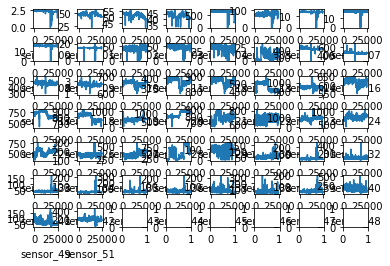

Интервал: 2


100%|██████████| 52/52 [00:01<00:00, 33.01it/s]


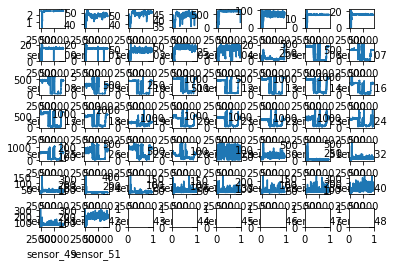

Интервал: 3


100%|██████████| 52/52 [00:00<00:00, 54.04it/s]


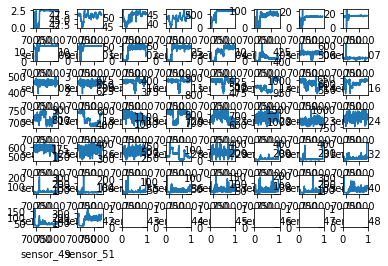

Интервал: 4


100%|██████████| 52/52 [00:01<00:00, 28.61it/s]


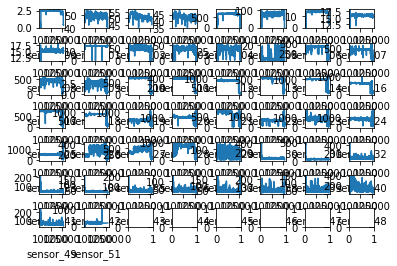

Интервал: 5


100%|██████████| 52/52 [00:01<00:00, 48.07it/s]


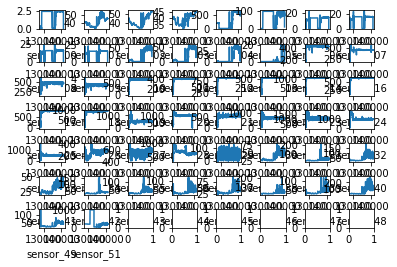

In [4]:
filename = 'sensor3.csv'
data = pd.read_csv(filename)

data_broken = data.loc[data['machine_status'].isin(['BROKEN'])] # оставляем только показания при состоянии BROKEN
broken_ids = data_broken.index.values # получаем список индексов поломок
broken_count = len(broken_ids) # получаем количество поломок

for i in range(0, broken_count - 2):
    print(f'Интервал: {i+1}')
    if i == 0:
        start = 1
    else:
        start = broken_ids[i] + 1 # задаем начальное значение среза, так как используем .iloc прибавляем единицу
    end = broken_ids[i + 1] # задаем конечное значение среза
    diapason = data.iloc[start:end, :] # выполняем срез по заданному диапазону
    fig, axes = plt.subplots(nrows = 7, ncols = 8) # создаем окно для вывода графиков в обрабатываемом диапазоне (с сеткой 7 на 8)
    # позиции для установки графика сенсора на свою позицию в сетке окна
    row = 0
    col = 0
    for i in tqdm(range(0, 52)): # проходимся по всем сенсорам
        if i not in [15, 50]:
            string = ''
            if i < 10: # так как в названиях сенсора есть 00, 01, 02... (жуть)
                string = '0' + str(i)
            else:
                string = str(i)
            # строим график по значениям сенсора
            diapason.plot(
                x = 'ID', 
                y = 'sensor_' + string, 
                ax = axes[row, col], # положение графика в сетке окна
                legend = False, # легенда мешает при выводе
                xlabel = 'sensor_' + string # чтобы понятно было где чей график
            )
            col += 1 # после установки графика смещаем следующий в следующую колонну
            if col == 8: # сетка 7 на 8, поэтому, когда колонны в строке кончаются, переходим на следующую строку
                row += 1 # переход на следующую строку
                col = 0 # новая строка - нумерация колонн сначала
    plt.subplots_adjust(wspace = 0.75, hspace = 0.75) # обозначаем расстояние между графиками
    plt.show()

## · Построим тепловые карты для оценки корреляции

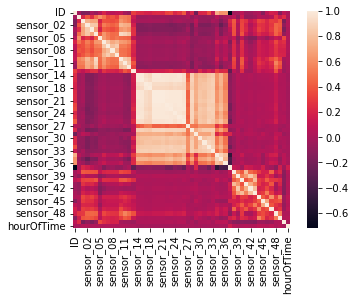

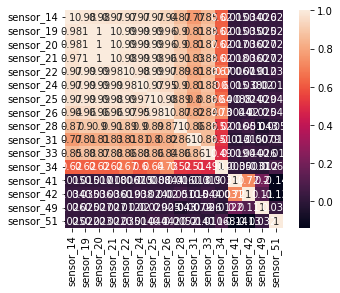

In [3]:
filename = 'sensor3.csv'
data = pd.read_csv(filename)
new_data = data.loc[ : , ['timestamp', 'sensor_14', 'sensor_19',  'sensor_20', 'sensor_21', 'sensor_22',
                           'sensor_24', 'sensor_25', 'sensor_26', 'sensor_28', 'sensor_31', 'sensor_33',
                           'sensor_34', 'sensor_41', 'sensor_42', 'sensor_49', 'sensor_51']]
sns.heatmap(data.corr(), square = True)
plt.show()
sns.heatmap(new_data.corr(), annot = True, square = True)
plt.show()

## · Найдем и визуализируем аномалии при помощи Isolation Forest

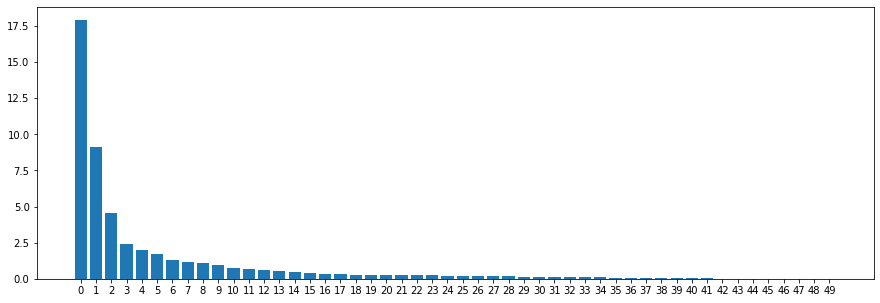

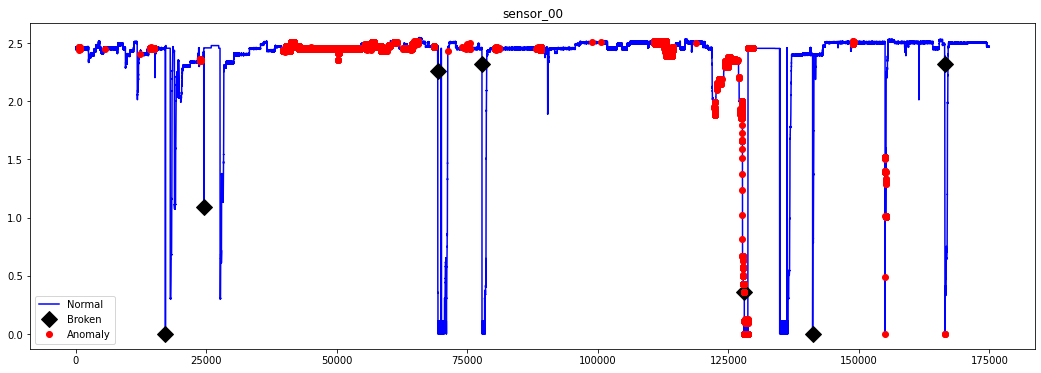

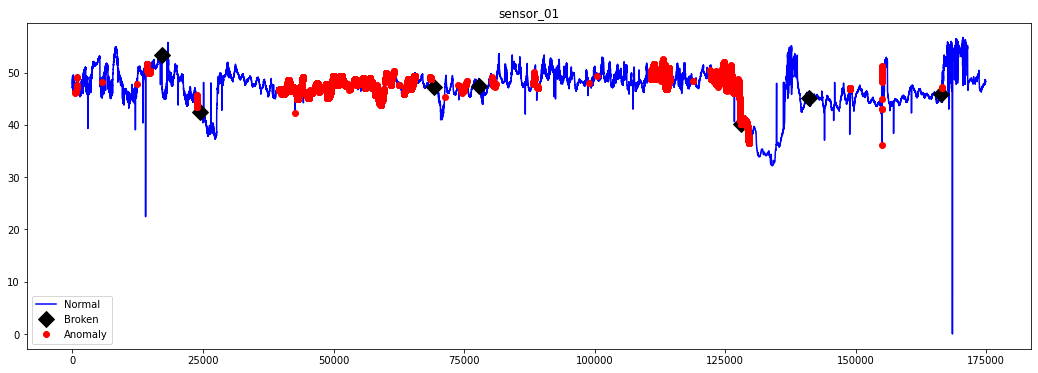

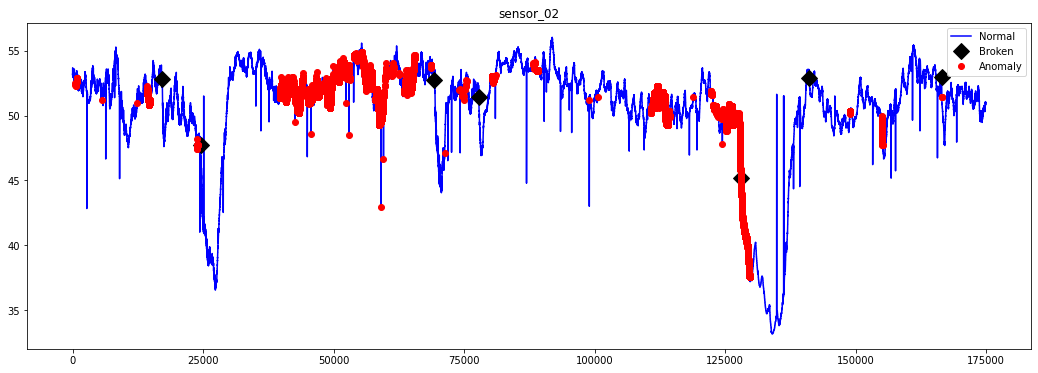

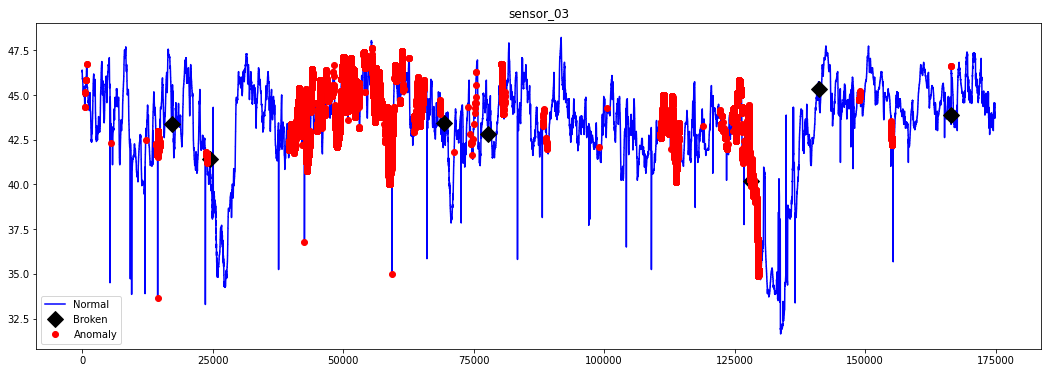

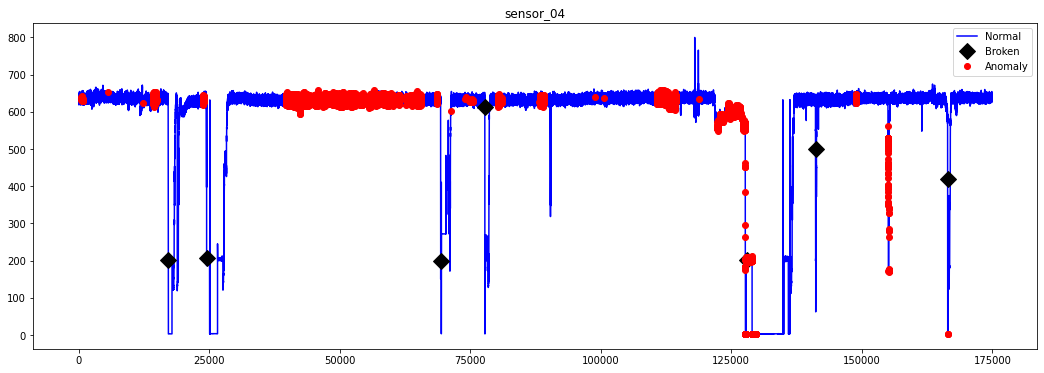

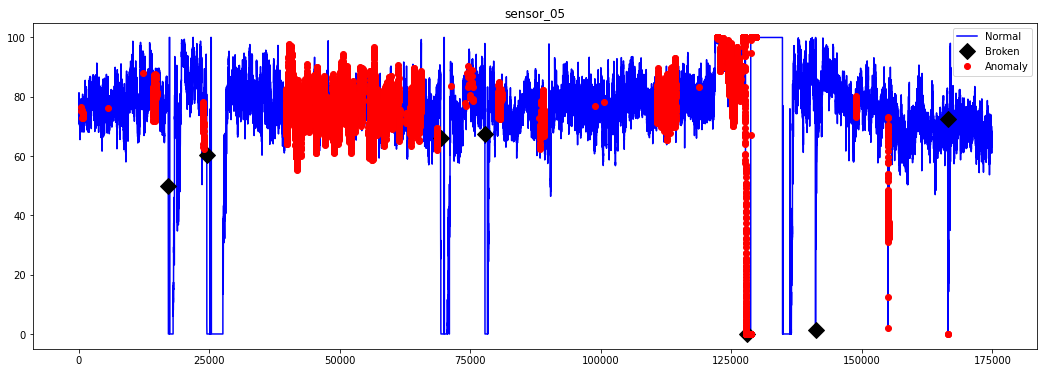

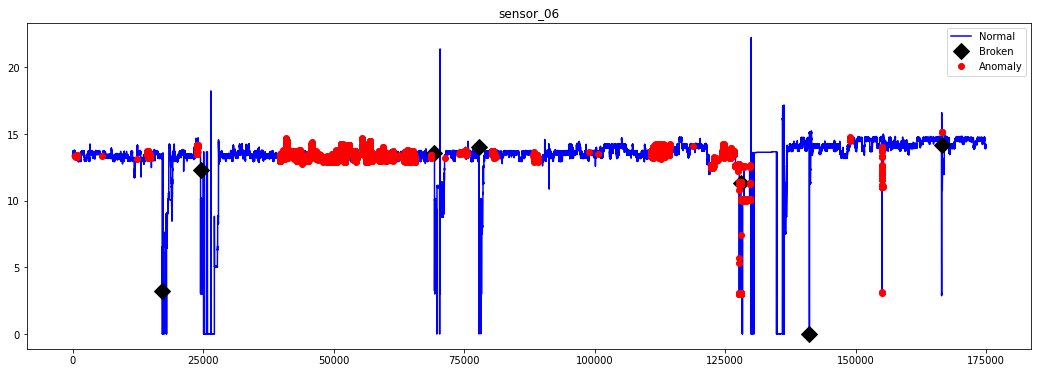

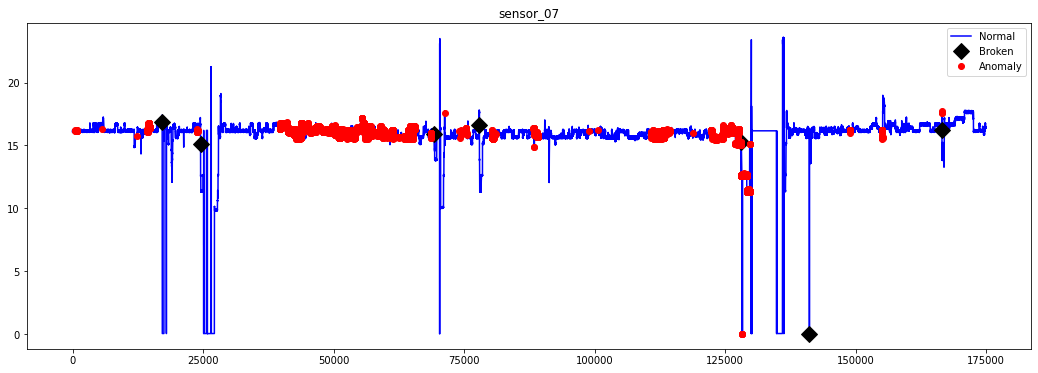

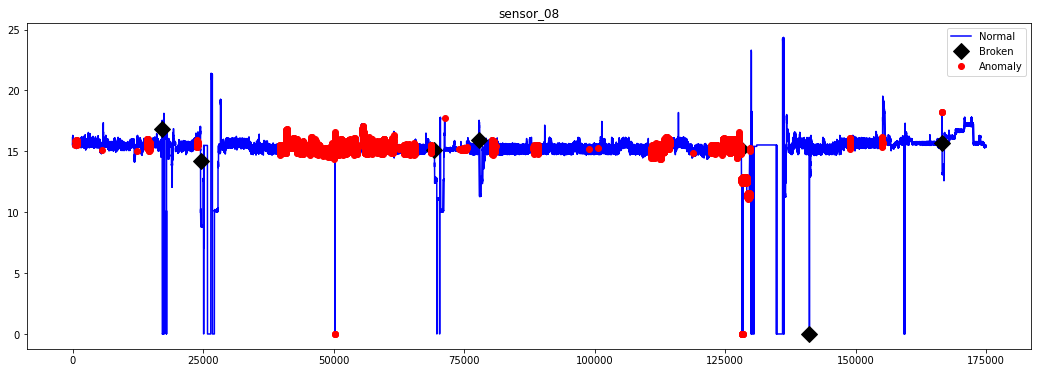

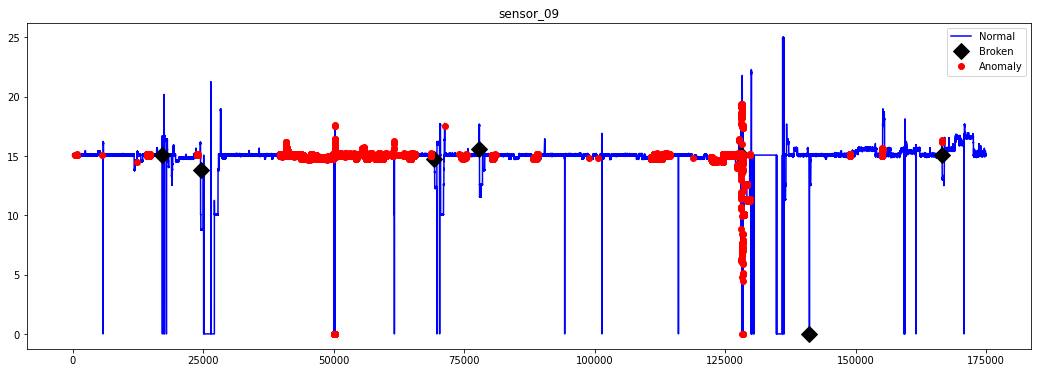

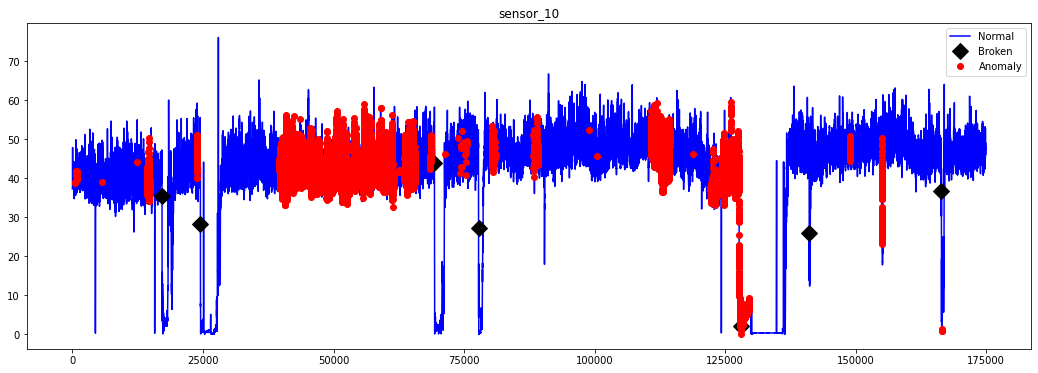

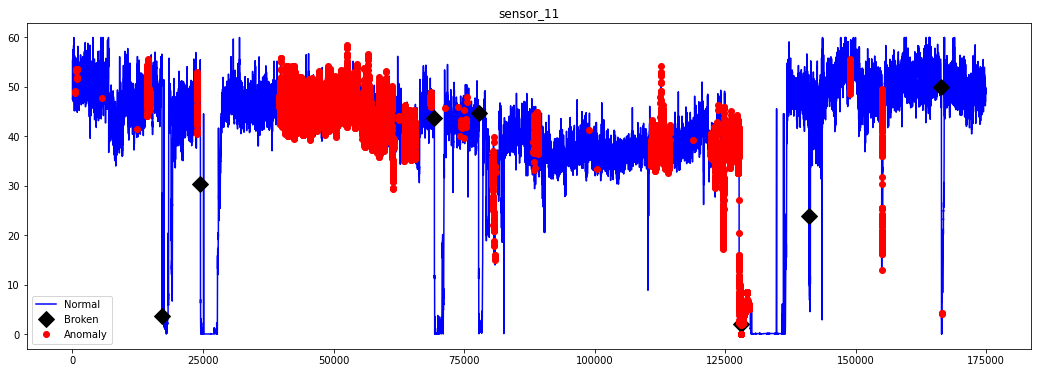

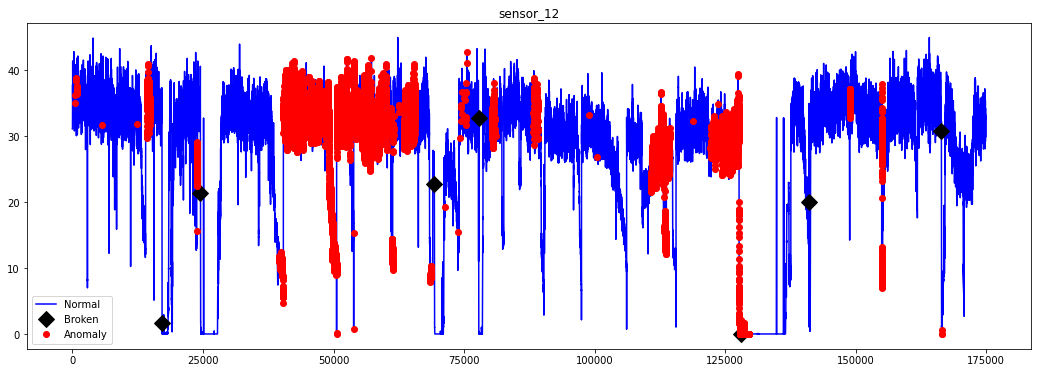

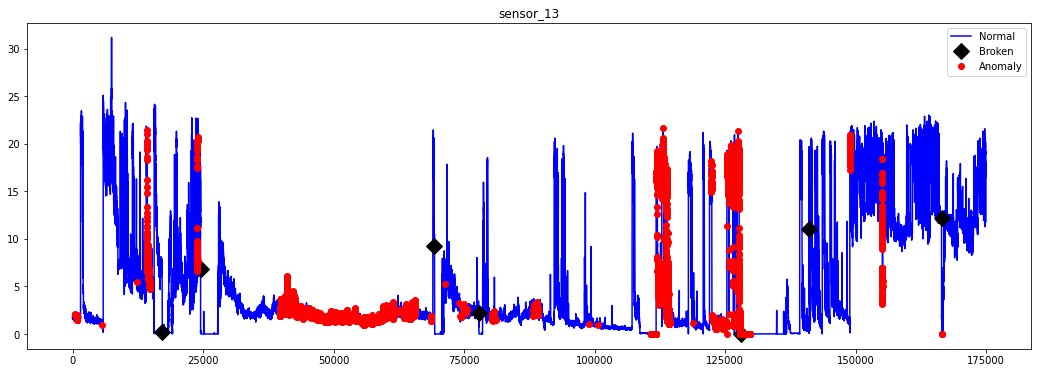

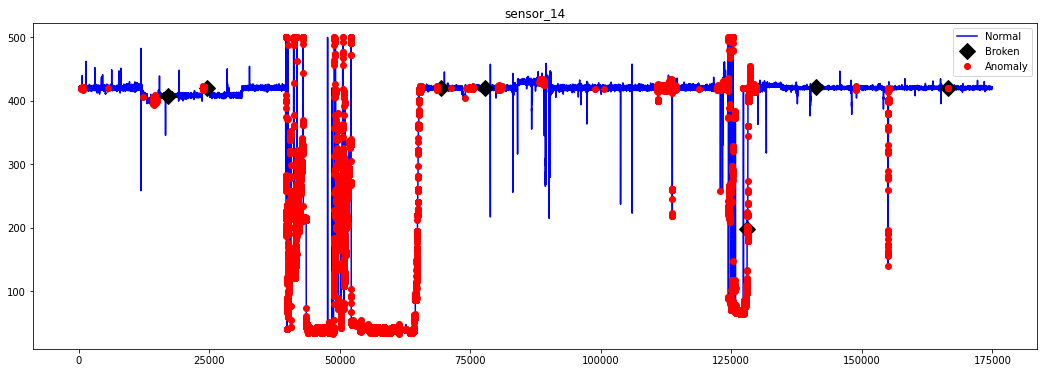

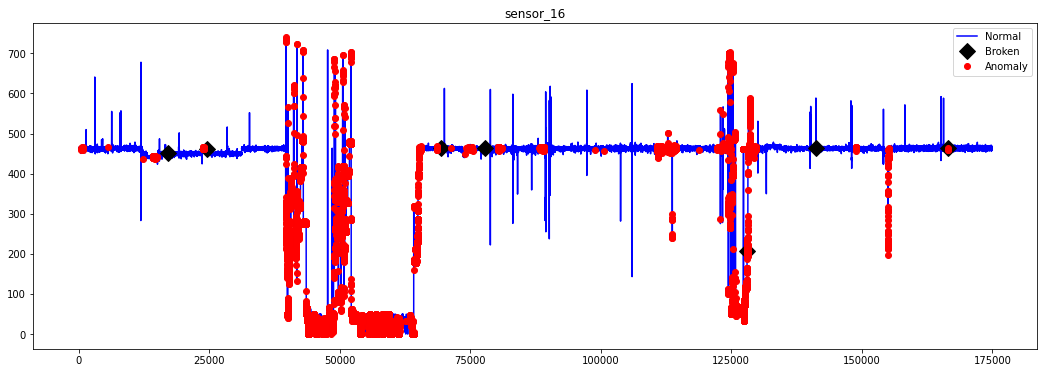

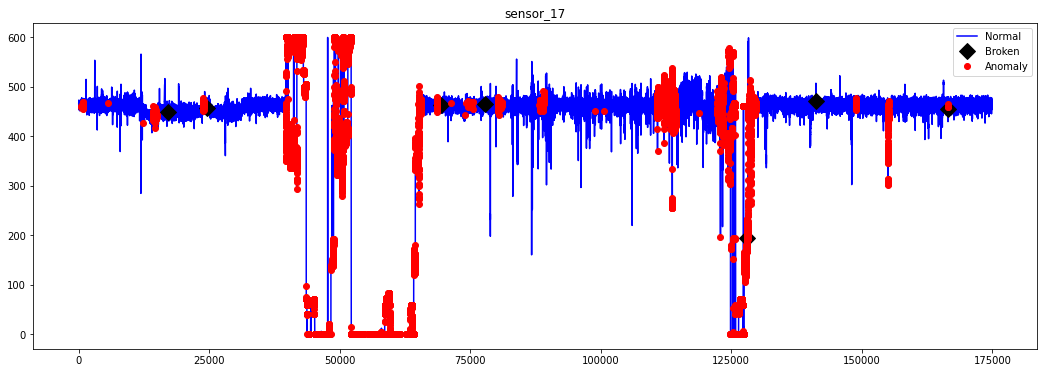

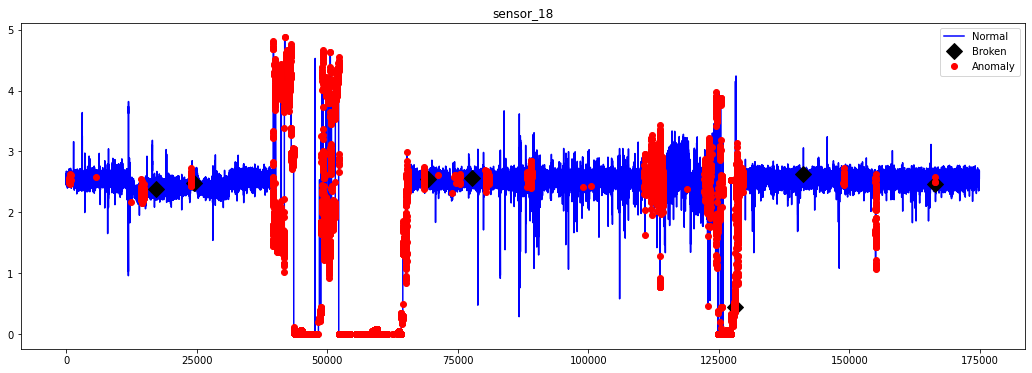

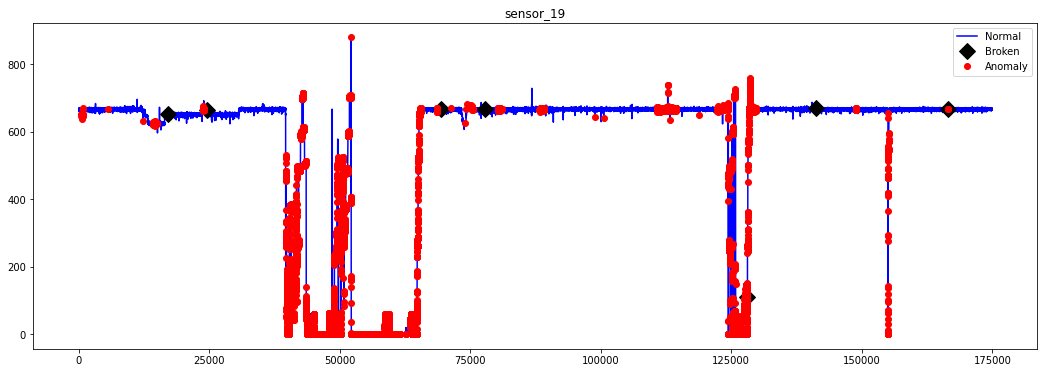

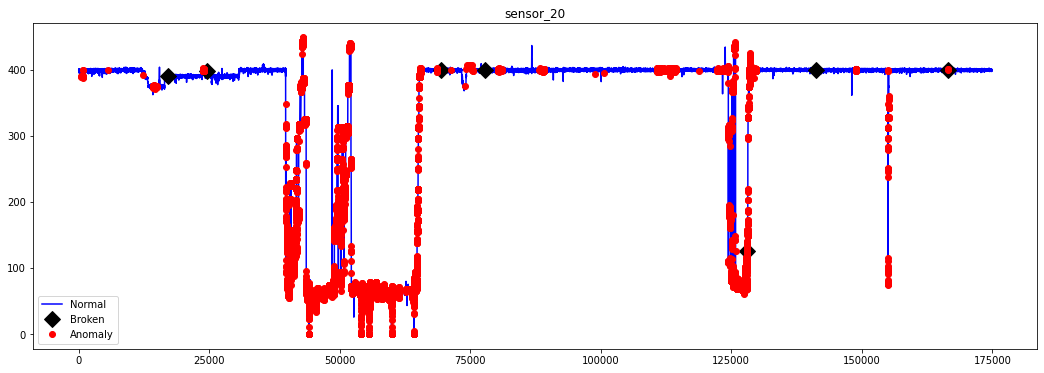

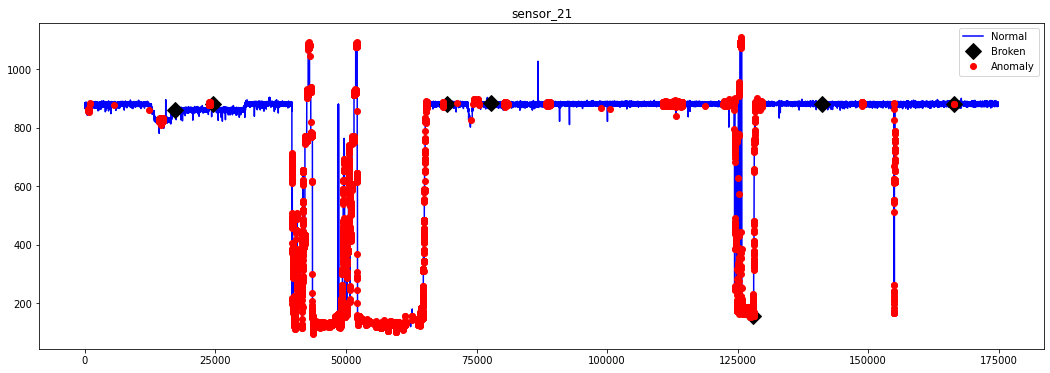

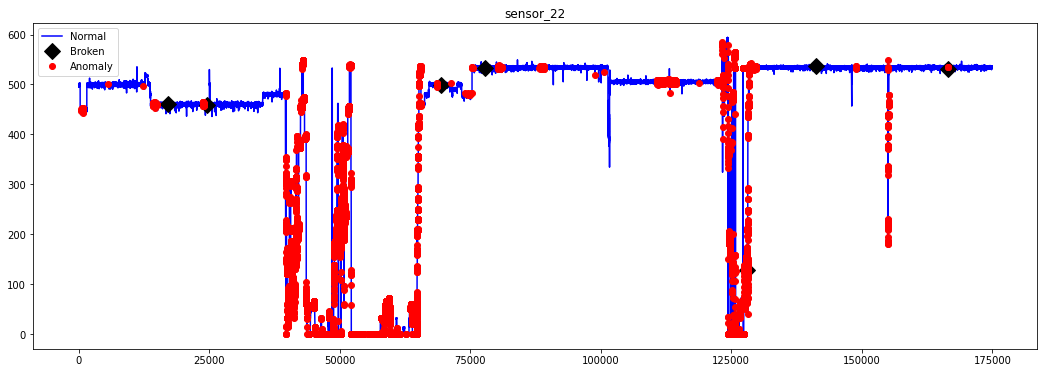

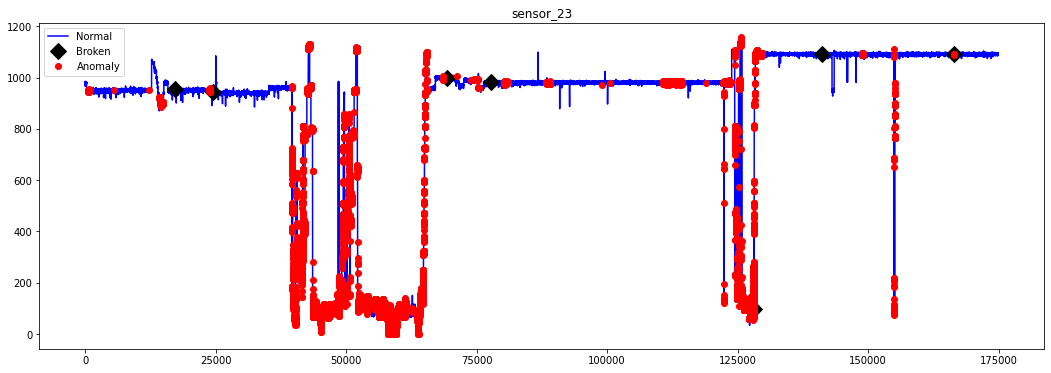

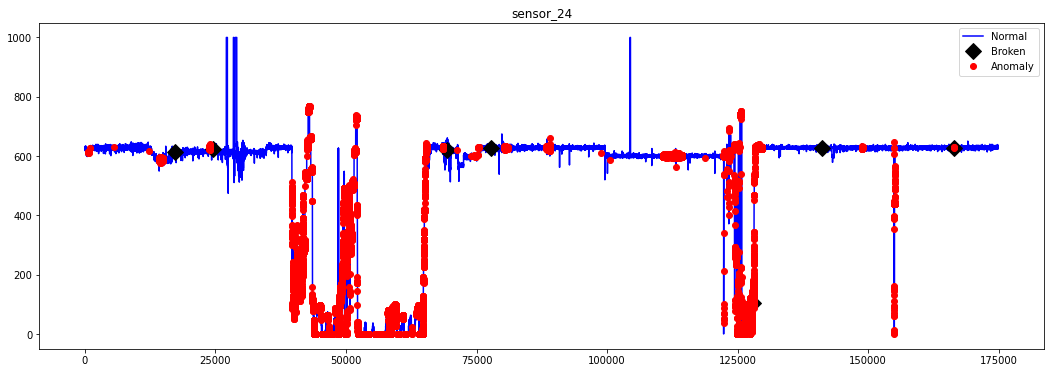

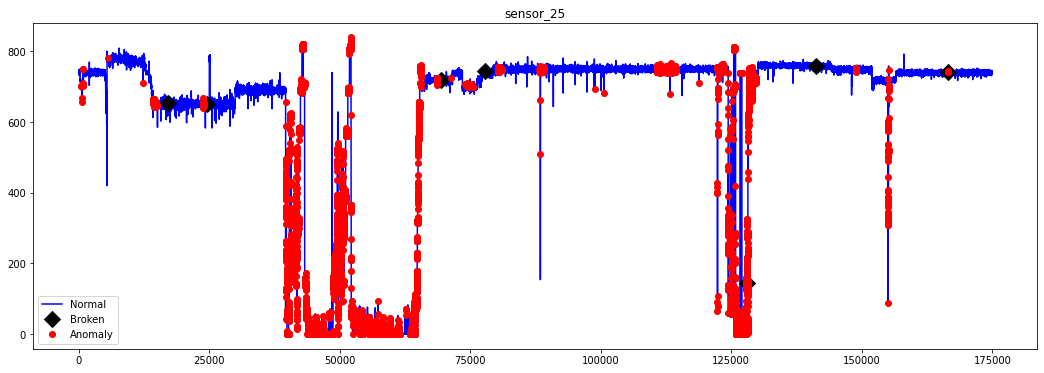

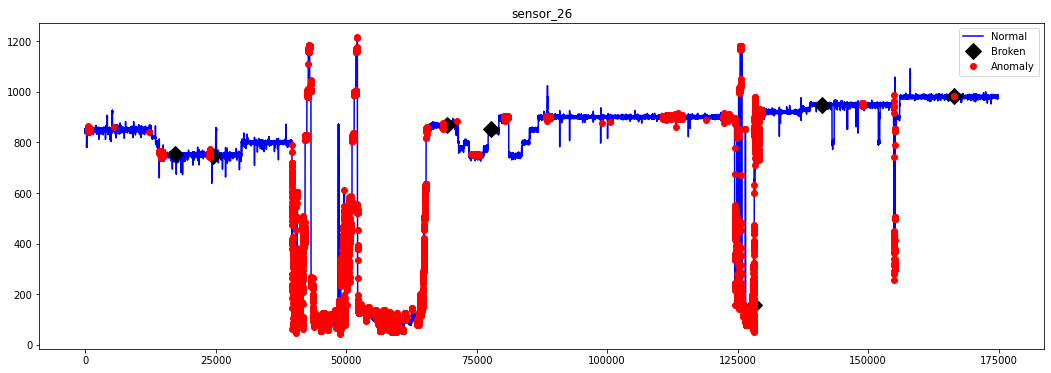

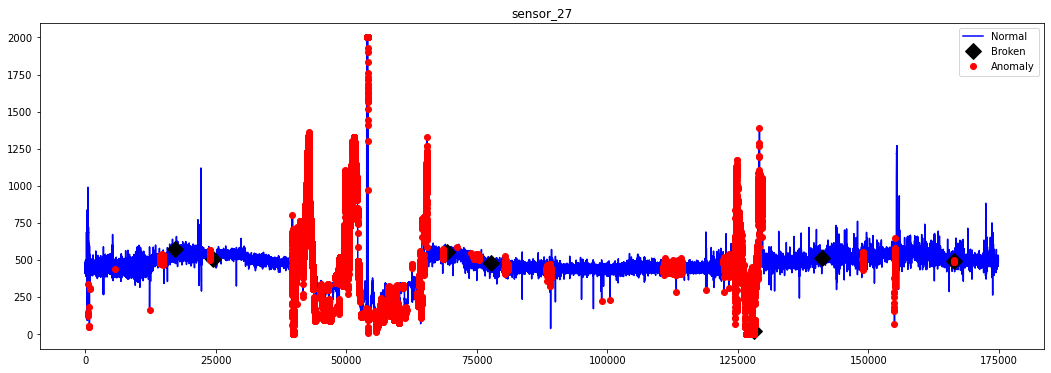

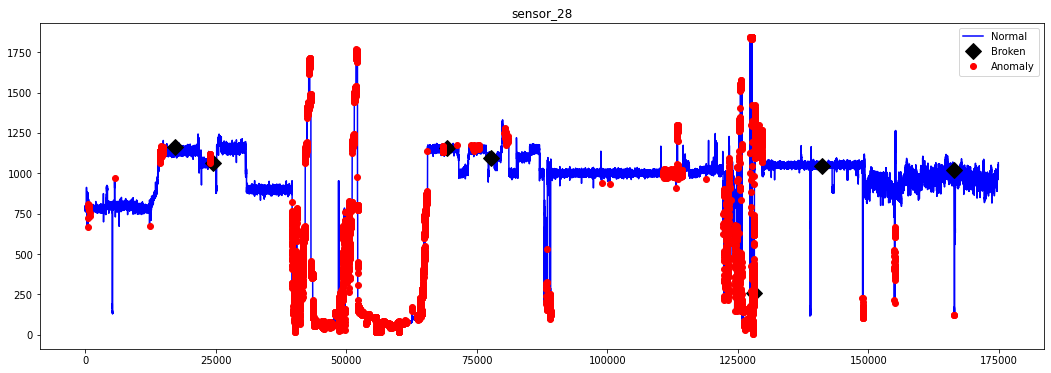

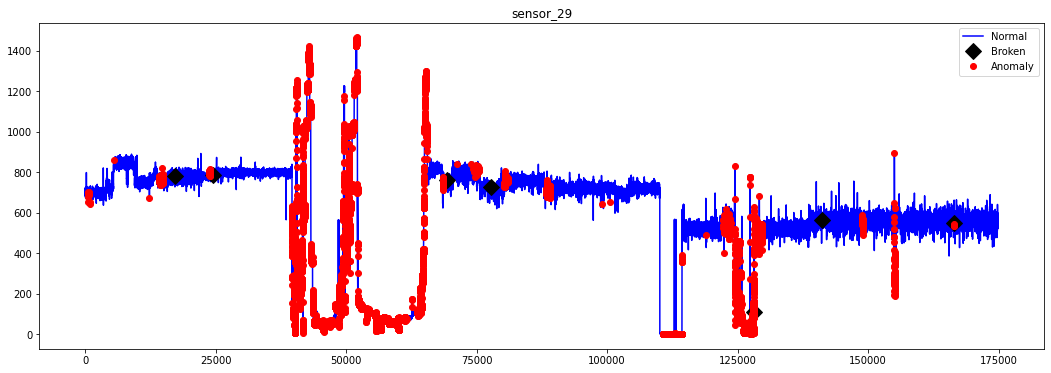

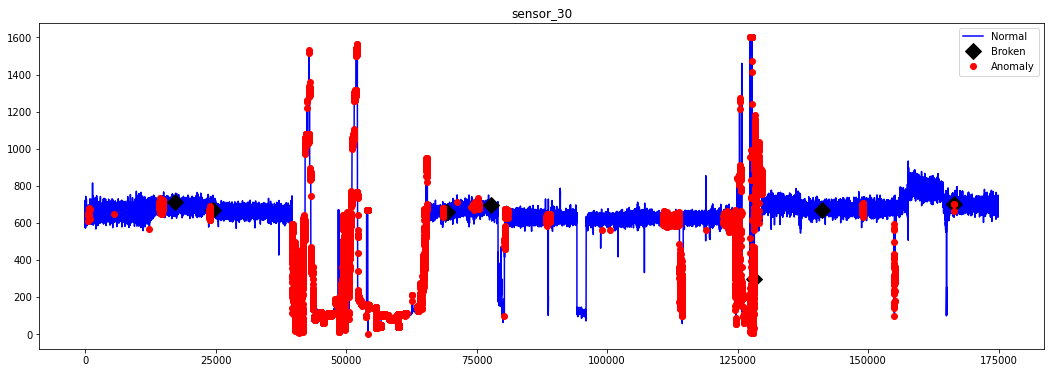

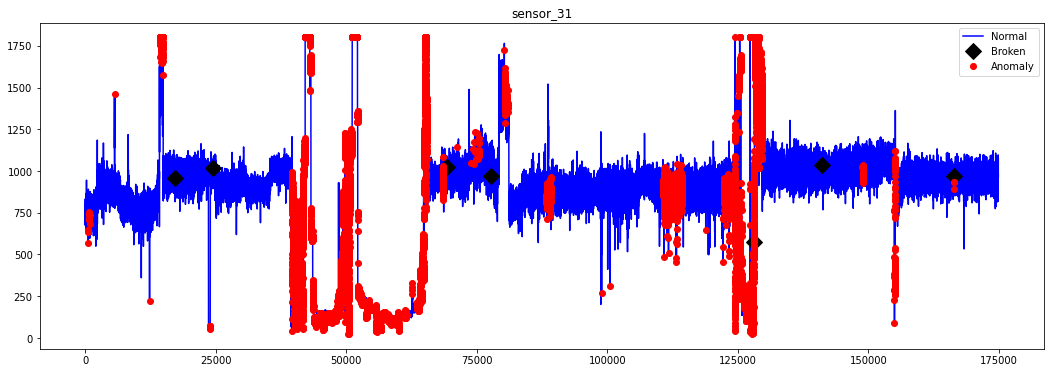

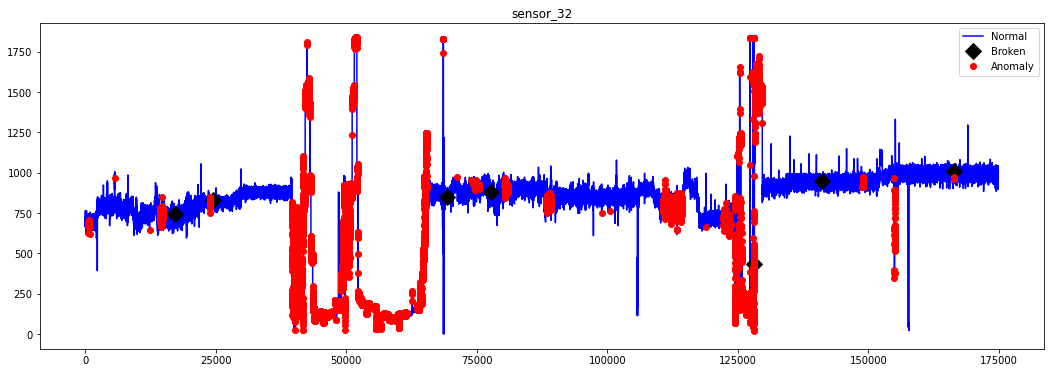

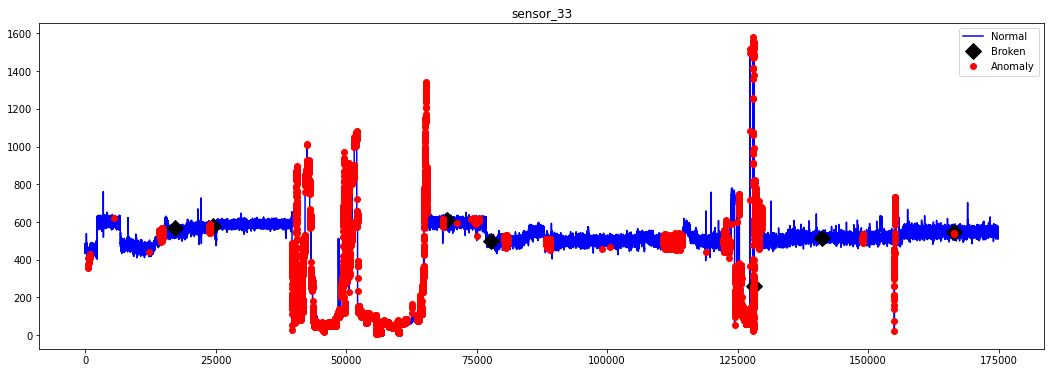

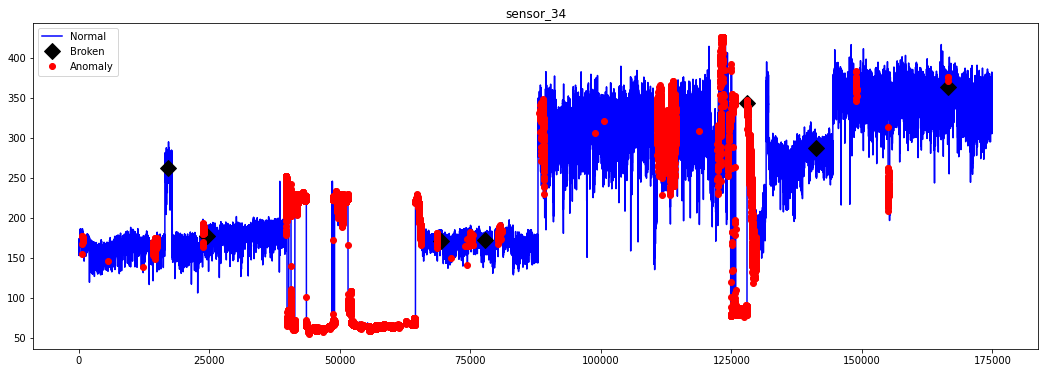

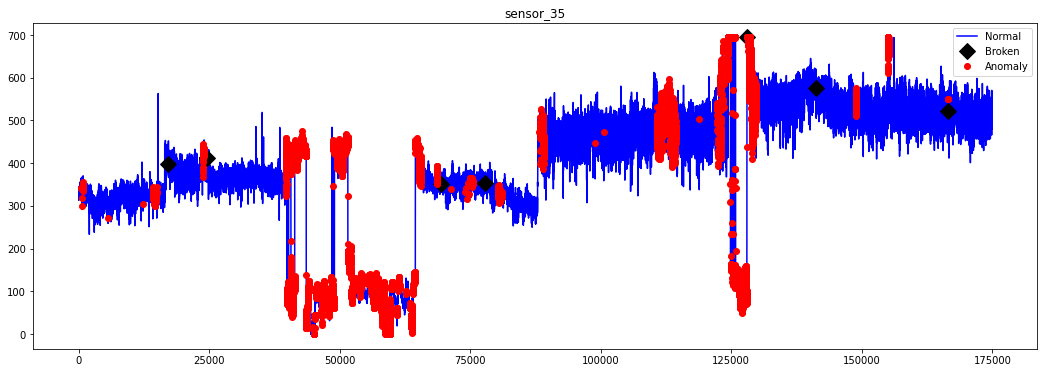

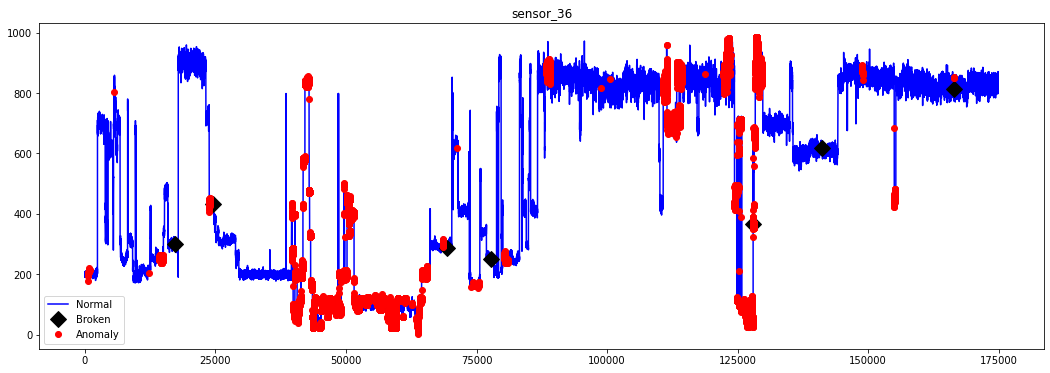

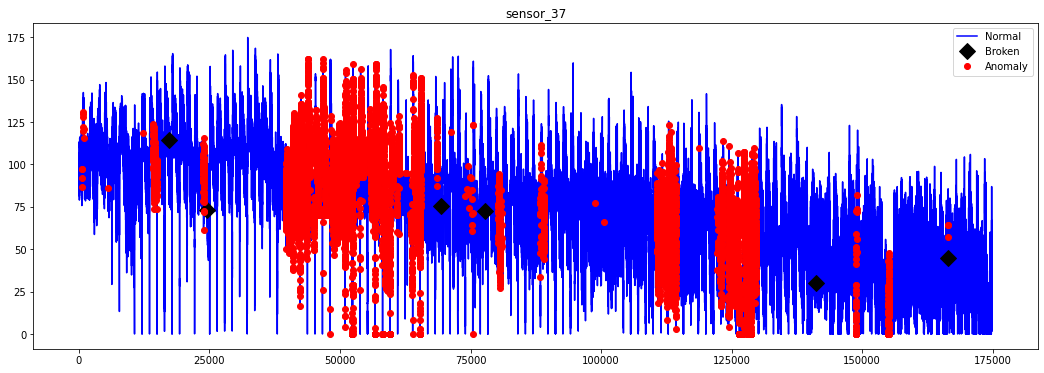

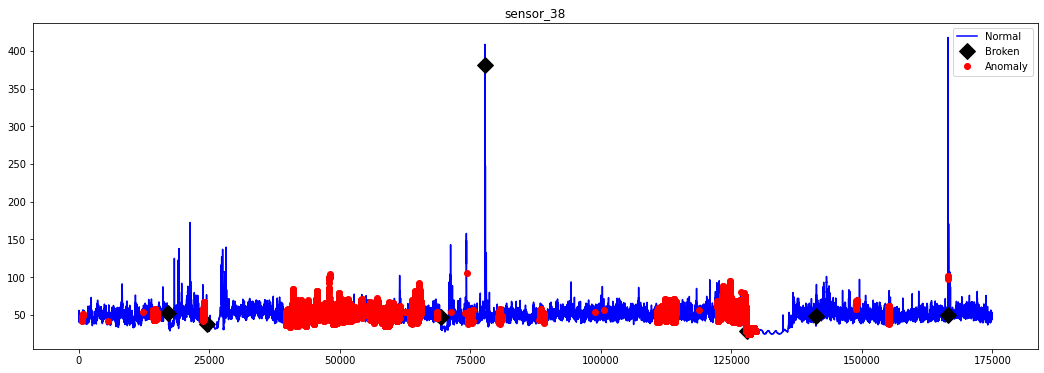

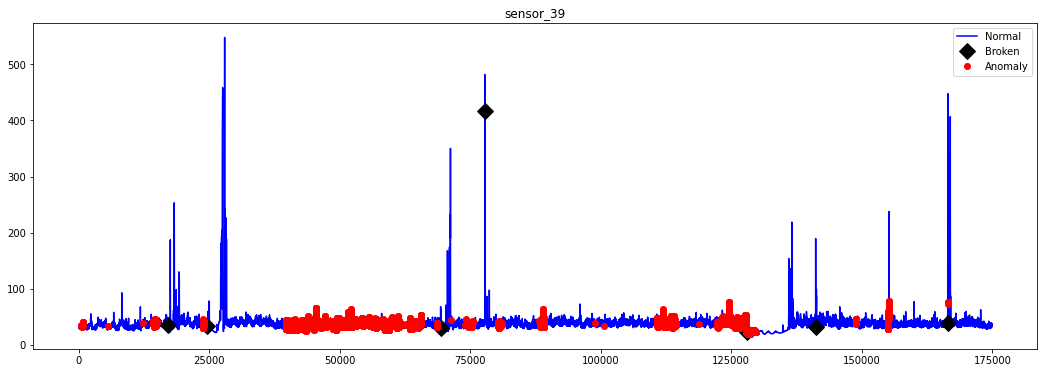

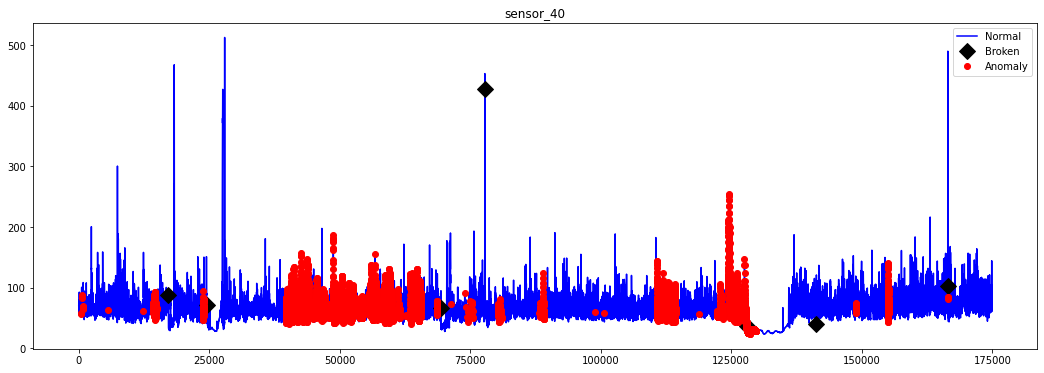

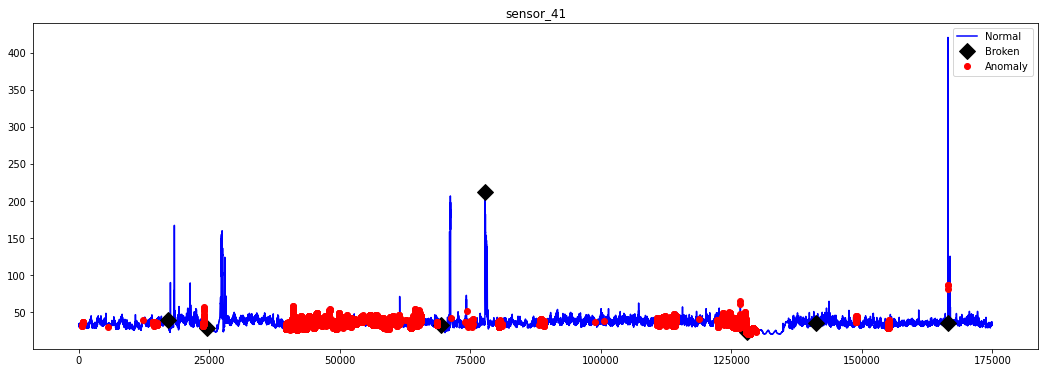

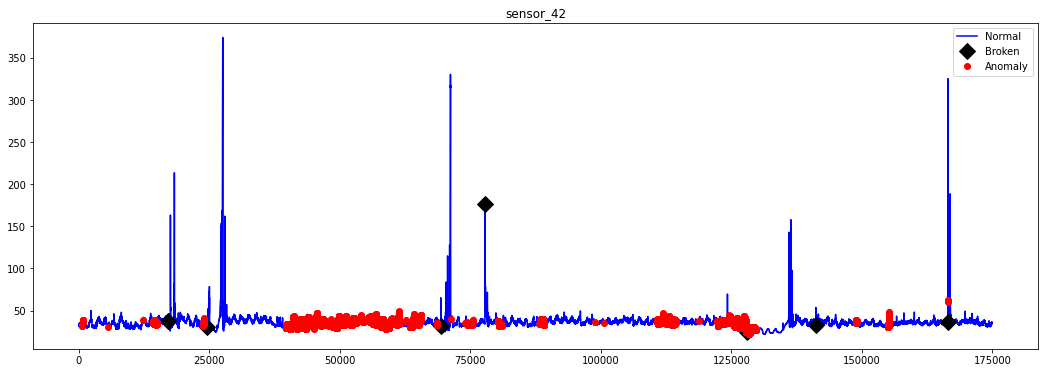

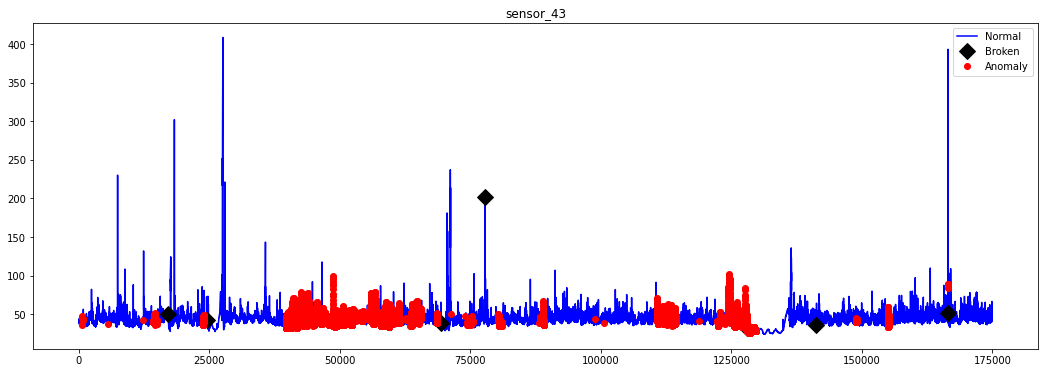

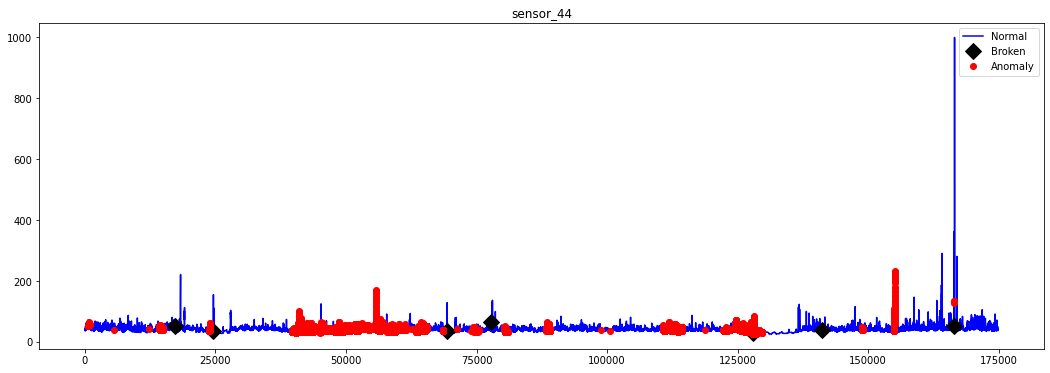

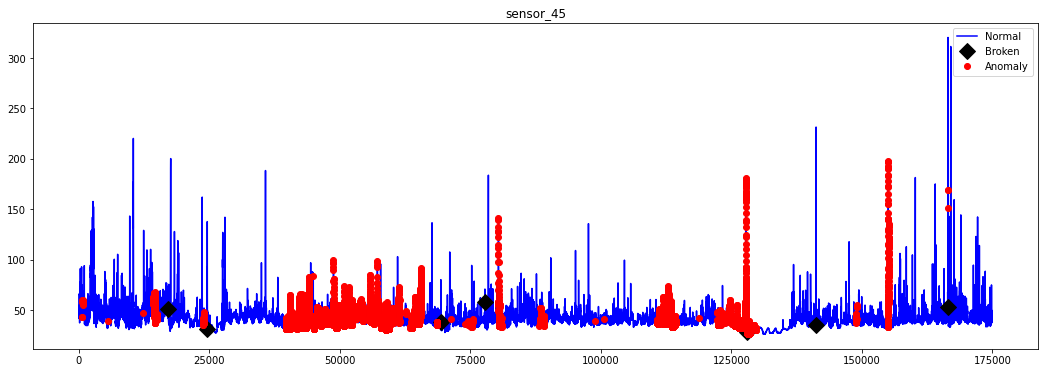

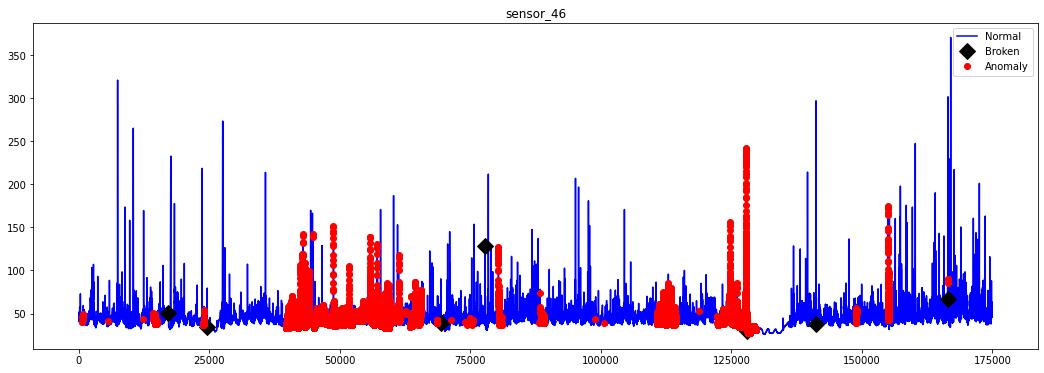

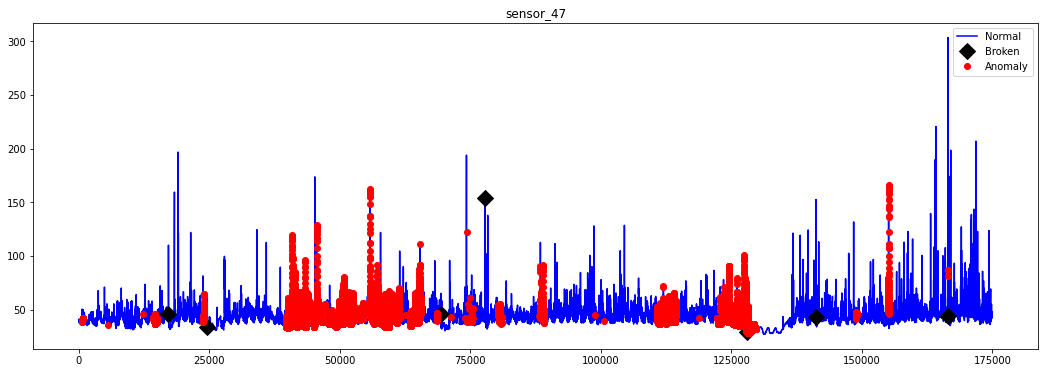

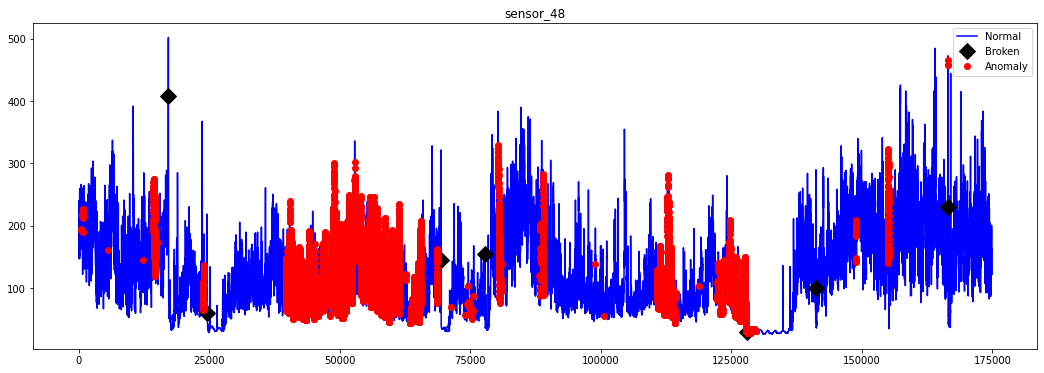

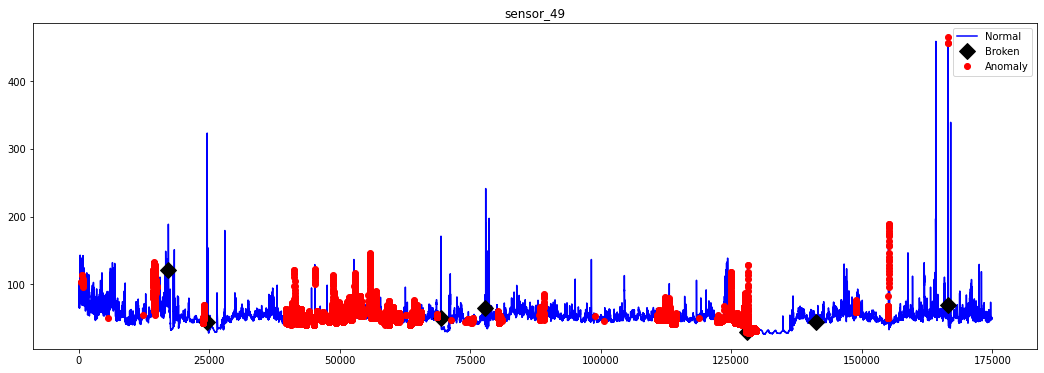

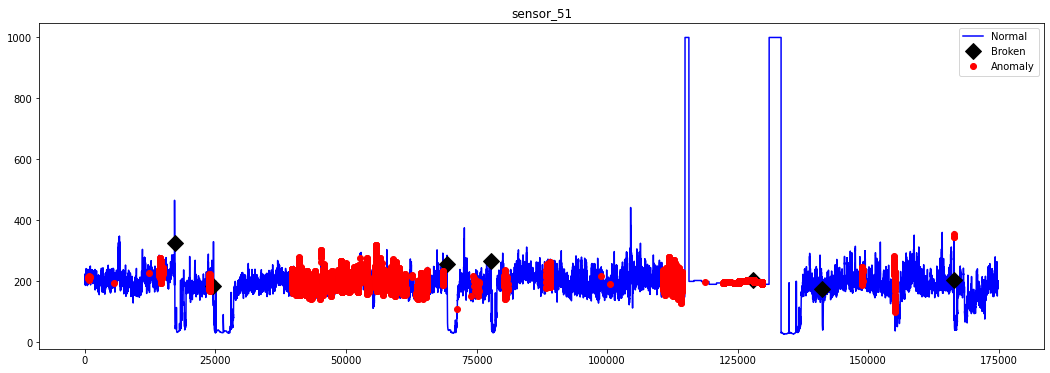

In [4]:
filename = 'sensor3.csv'
data = pd.read_csv(filename)

# Получим значения при статусе BROKEN
broken = data[data['machine_status']=='BROKEN']
# Оставим только значения сенсоров
data2 = data.drop(['ID', 'time_weekDays', 'time_dayTimes', 'machine_status', 'hourOfTime', 'timestamp'], axis=1)
names=data2.columns

# Масштабируем данные
# Выполним PCA и посмотрим на наиболее важные основные компоненты, основанные на инерции
x = data[names]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

features = range(pca.n_components_)
plt.figure(figsize=(15, 5))
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.show()


# Похоже, что первые два основных компонента являются наиболее важными в соответствии с функциями, извлеченными PCA на графике важности
# Выполним PCA с двумя компонентами, которые будут моими функциями, которые будут использоваться при обучении моделей
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principaldata = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
data['pc1'] = principaldata['pc1']
data['pc2'] = principaldata['pc2']

# Предположим, что 13% всего набора данных являются аномалиями.
outliers_fraction = 0.13
model =  IsolationForest(contamination=outliers_fraction)
model.fit(principaldata.values) 
principaldata['anomaly2'] = pd.Series(model.predict(principaldata.values))

# Строим графики
data['anomaly2'] = pd.Series(principaldata['anomaly2'].values, index=data.index)
anomaly = data.loc[data['anomaly2'] == -1] #anomaly
for name in names:
    plt.figure(figsize=(18,6))
    plt.plot(data[name], color='blue', label='Normal')
    plt.plot(broken[name], linestyle='none', marker='D', color='black', markersize=12, label='Broken')
    plt.plot(anomaly[name], linestyle='none', marker='.', color='red', markersize=12, label='Anomaly')
    plt.title(f'{name}')
    plt.legend(loc='best')
    plt.show()
